## Action Plan
### Build model by LUNA to train Data Bowl 2017
1. Data Preprocessing on Data Bowl 2017 data
2. Data Preprocessing on LUNA data for **generate Regions of Interest candidates by Segmentation** 
3. Train Model to **generate Regions of Interest candidates by Segmentation** 
4. Data Preprocessing on LUNA data for **Classification of Lung Nodules **
5. Train Model for **Classification of Lung Nodules **
6. Generate and Validate Predictions 
7. Submit predictions to Kaggle

## Constructing a training set from the LUNA 2016 data


We are going to use the nodule locations as given in annotations.csv and extract three transverse slices that contain the largest nodule from each patient scan. Masks will be created for those slices based on the nodule dimensions given in annotations.csv. The output of this file will be two files for each patient scan: a set of images and a set of corresponding nodule masks. The data from the LUNA 2016 challenge can be found at https://luna16.grand-challenge.org/

First we import the necessary tools and find the largest nodule in the patient scan. There are multiple nodule listings for some patients in annotations.csv. We're using a pandas DataFrame named ```df_node``` to keep track of the case numbers and the node information. The node information is an (x,y,z) coordinate in mm using a coordinate system defined in the .mhd file. 

The following snippets of code are from [LUNA_mask_extraction.py](./tutorial_code/LUNA_mask_extraction.py):

In [2]:
import os
luna_path = "../input/LUNA16/"
luna_subset_path = "../input/LUNA16/subset0/"
output_path = "../input/LUNA16/output/"
if not os.path.exists(output_path): os.makedirs(output_path)

In [1]:
from importlib import reload
import dataprep_LUNA; reload(dataprep_LUNA)
from dataprep_LUNA import *
import utils_LUNA; reload(utils_LUNA)
from utils_LUNA import *

In [3]:
file_list=glob(luna_subset_path+"*.mhd")
print(len(file_list))

89


In [4]:
#
# The locations of the nodes
df_node = pd.read_csv(luna_path+"annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename, args=(file_list,))
df_node = df_node.dropna()

In [5]:
print(len(df_node))
df_node[:5]

112


,seriesuid,coordX,coordY,coordZ,diameter_mm,file
23,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,-100.567944,67.260517,-231.816619,6.440879,../input/LUNA16/subset0/1.3.6.1.4.1.14519.5.2....
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,../input/LUNA16/subset0/1.3.6.1.4.1.14519.5.2....
26,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.392044,76.771663,-123.321911,4.343200,../input/LUNA16/subset0/1.3.6.1.4.1.14519.5.2....
28,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,136.434059,117.765579,-181.947817,4.681382,../input/LUNA16/subset0/1.3.6.1.4.1.14519.5.2....
86,1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048...,145.967465,-161.197634,-312.071347,6.378436,../input/LUNA16/subset0/1.3.6.1.4.1.14519.5.2....


## Getting the nodule position in the mhd files

The nodule locations are given in terms of millimeters relative to a coordinate system defined by the CT scanner. The image data is given as a varying length stack of 512 X 512 arrays. In order to translate the voxel position to the world coordinate system, one needs to know the real world position of the [0,0,0] voxel and the voxel spacing in mm. 

In [7]:
get_images_and_masks_by_nodule_position(luna_subset_path, output_path, 
                                        annotation_fname=luna_path+"annotations.csv", 
                                        resampling=True)

total .mhd file: 89
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd
Getting mask for image file 1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd
Getting ma

Check to make sure the nodule masks look as expected:

image 0


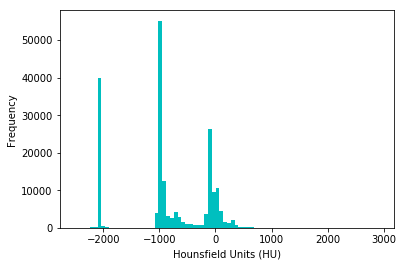

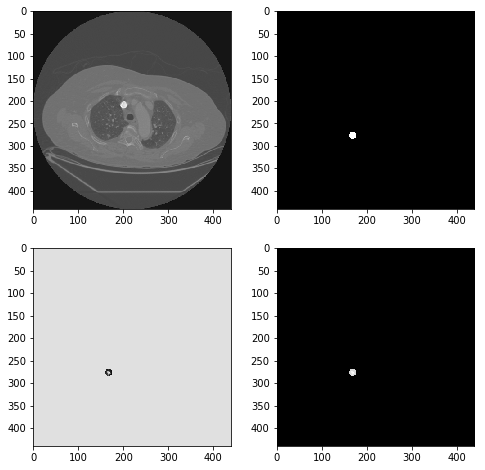

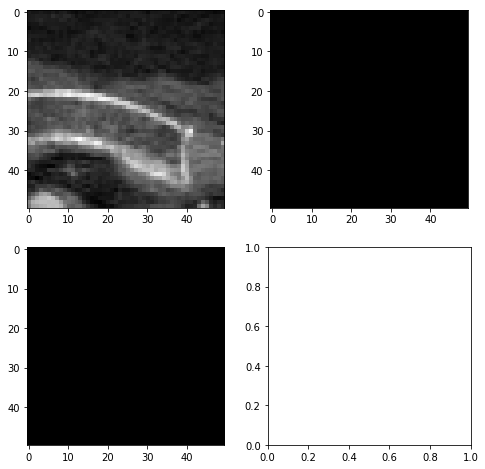

image 1


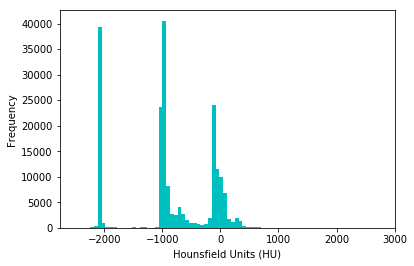

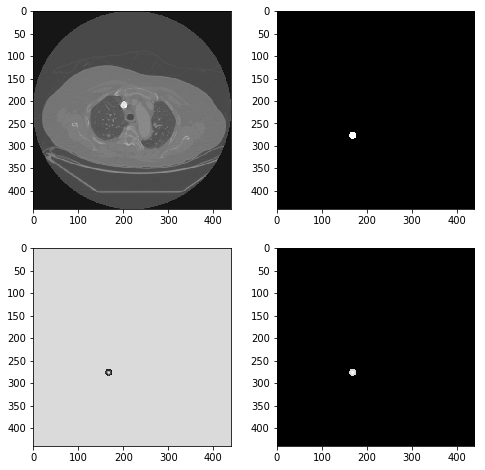

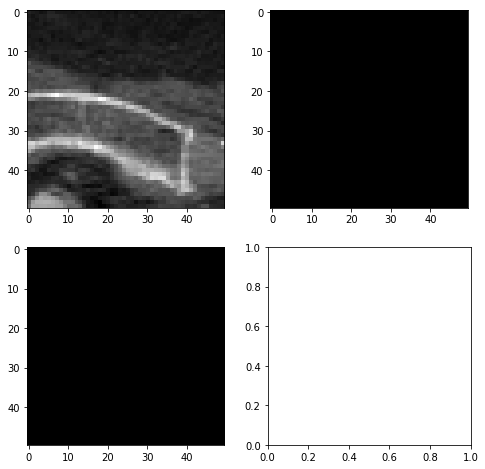

image 2


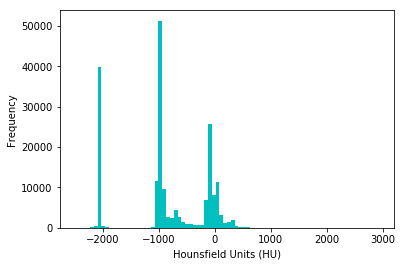

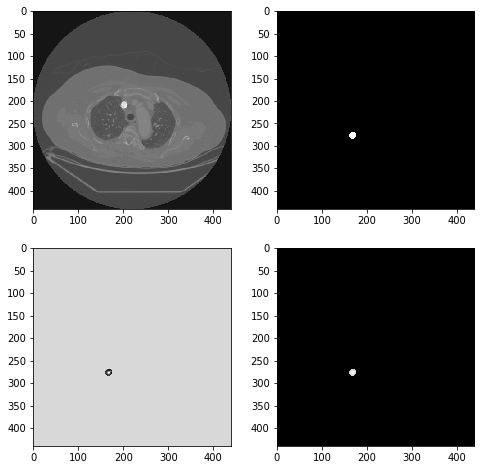

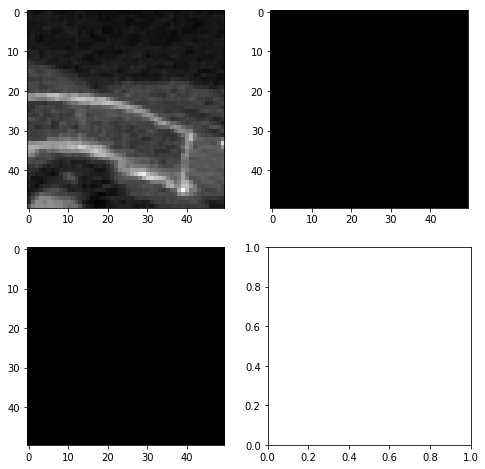

In [9]:
fcount, node_idx = (11, 130) # pc: (0, 23), (2, 25), (3, 28), (8, 103), (9, 110) (10, 117) (11, 130)
    # aws: (0, 1116), (1, 938), (3, 1138), (8, 347), (9, 117) (8, 347)
xzoom = slice(220, 270)
yzoom = slice(150, 200)

imgs = np.load(output_path+'images_%04d_%04d.npy' % (fcount, node_idx))
masks = np.load(output_path+'masks_%04d_%04d.npy' % (fcount, node_idx))
spacing = np.load(output_path+'spacing_%04d_%04d.npy' % (fcount, node_idx))
'''
imgs_resampled = np.load(output_path+'images_resampled_%04d_%04d.npy' % (fcount, node_idx))
masks_resampled = np.load(output_path+'masks_resampled_%04d_%04d.npy' % (fcount, node_idx))
newspacing = np.load(output_path+'newspacing_%04d_%04d.npy' % (fcount, node_idx))
'''
for i in range(len(imgs)):
    #print(newspacing)
    print("image %d" % i)
    plt.hist(imgs[i].flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(masks[i],cmap='gray')
    ax[1,0].imshow(imgs[i]*masks[i],cmap='gray')
    ax[1,1].imshow((matrix2uint16(imgs[i])*masks[i]),cmap='gray')
    fig,ax = plt.subplots(2,2,figsize=[8,8])
    ax[0,0].imshow(imgs[i][yzoom, xzoom],cmap='gray')
    ax[0,1].imshow(masks[i][yzoom, xzoom],cmap='gray')
    ax[1,0].imshow(imgs[i][yzoom, xzoom]*masks[i][yzoom, xzoom],cmap='gray')
    plt.show()

The image on the top left is the scan slice. The image on the top right is the node mask. The image on the bottom left is the masked slice, highlighting the node. 

![Example LUNA Mask](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/example_luna_mask.png)

Close up on the nodule : 

![Example LUNA Mask detail](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/example_luna_mask_detail.png)

## Isolation of the Lung Region of Interest to Narrow Our Nodule Search

The node masks seem to be constructed properly. The next step is to isolate the lungs in the images. We'll need
to import some skimage image processing modules for this step. The general strategy is to threshold the image to isolate the 
regions within the image, and then to identify which of those regions are the lungs. The lungs have a high constrast with the surrounding tissue, so the thresholding is fairly straightforward. We use some ad-hoc criteria for eliminating the non-lung regions from the image which do not apply equally to all data sets. 

### Erosion and Dilation

We then use an erosion and dilation to fill in the incursions into the lungs region by radio-opaque tissue, followed by a selection of the regions based on the bounding box sizes of each region. 

In [11]:
file_list=glob(output_path+"images*.npy")
#file_list=glob(output_path+"images_resampled*.npy")
print(len(file_list))

112


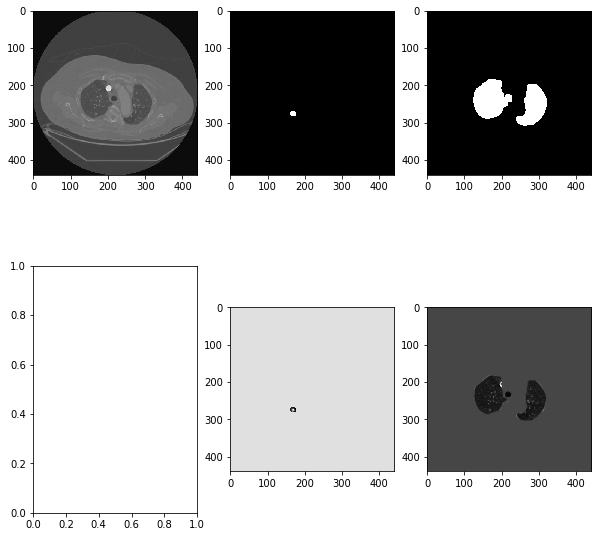

In [22]:
fcount, node_idx = (11, 130)  # pc: (1, 23), problem (2, 25), (3, 28), (8, 103), (9, 110) (10, 117) (11, 130)
    # aws: (0, 1116), (1, 938), (3, 1138), (8, 347), (9, 117) (8, 347)
imgs = np.load(output_path+'images_%04d_%04d.npy' % (fcount, node_idx))
masks = np.load(output_path+'masks_%04d_%04d.npy' % (fcount, node_idx))
       
segmented_lungs_fill = segment_lung_mask(imgs, fill_lung_structures=True)
#segmented_lungs_fill
i = 0
fig,ax = plt.subplots(2,3,figsize=[10,10])
ax[0,0].imshow(imgs[i],cmap='gray')
ax[0,1].imshow(masks[i],cmap='gray')
ax[0,2].imshow(segmented_lungs_fill[i],cmap='gray')
ax[1,1].imshow(imgs[i]*masks[i],cmap='gray')
ax[1,2].imshow(imgs[i]*segmented_lungs_fill[i],cmap='gray')
plt.show()        
    #np.save(img_file.replace("images","lungmask"), segmented_lungs_fill)

In [196]:
get_segment_lung_mask(output_path, fill_lung_structures=True)

total images: 112
on image ../input/LUNA16/output/images_0063_1123.npy
on image ../input/LUNA16/output/images_0027_0790.npy
on image ../input/LUNA16/output/images_0076_0135.npy
on image ../input/LUNA16/output/images_0073_0979.npy
on image ../input/LUNA16/output/images_0029_0456.npy
on image ../input/LUNA16/output/images_0078_0794.npy
on image ../input/LUNA16/output/images_0062_1108.npy
on image ../input/LUNA16/output/images_0020_1072.npy
on image ../input/LUNA16/output/images_0054_0622.npy
on image ../input/LUNA16/output/images_0043_0335.npy
on image ../input/LUNA16/output/images_0068_0792.npy
on image ../input/LUNA16/output/images_0009_0117.npy
on image ../input/LUNA16/output/images_0019_1074.npy
on image ../input/LUNA16/output/images_0032_0420.npy
on image ../input/LUNA16/output/images_0076_0136.npy
on image ../input/LUNA16/output/images_0007_1049.npy
on image ../input/LUNA16/output/images_0011_0988.npy
on image ../input/LUNA16/output/images_0008_0347.npy
on image ../input/LUNA16/out

image 0


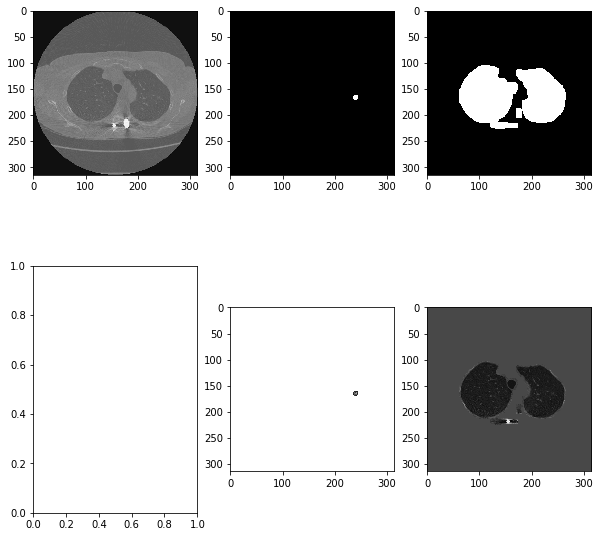

image 1


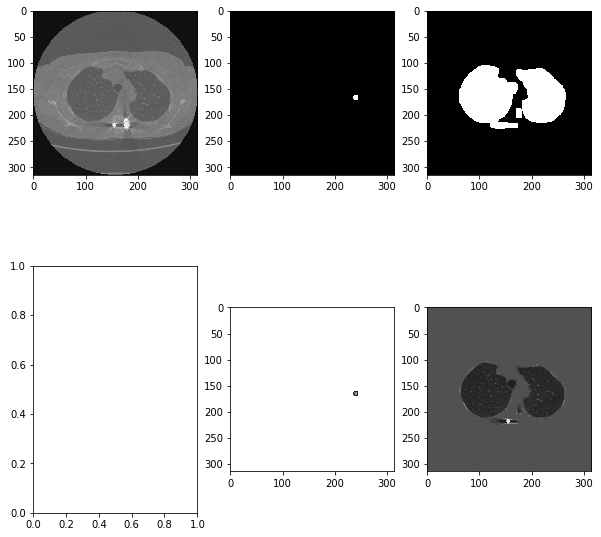

image 2


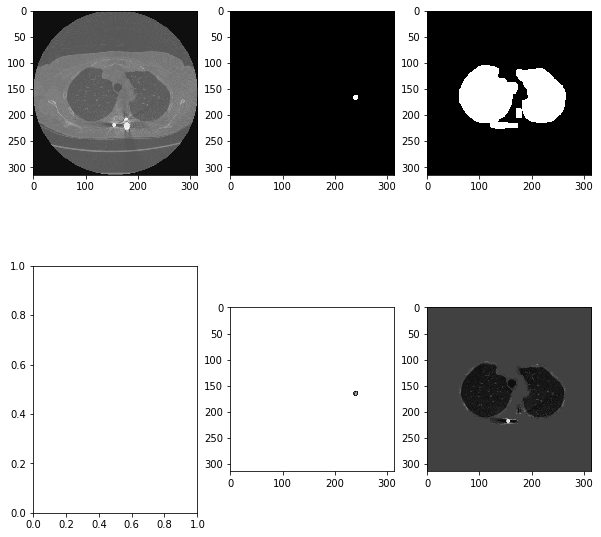

In [197]:
fcount, node_idx = (9, 117) #(0, 1116), (1, 938), (3, 1138), (8, 347), (9, 117)
imgs = np.load(output_path+'images_%04d_%04d.npy' % (fcount, node_idx))
masks = np.load(output_path+'masks_%04d_%04d.npy' % (fcount, node_idx))
segmented_lungs_fill = np.load(output_path+'lungmask_%04d_%04d.npy' % (fcount, node_idx))
#segmented_lungs_fill = segment_lung_mask(imgs, True)

for i in range(len(imgs)):
    print("image %d" % i)
    fig,ax = plt.subplots(2,3,figsize=[10,10])
    ax[0,0].imshow(imgs[i],cmap='gray')
    ax[0,1].imshow(masks[i],cmap='gray')
    ax[0,2].imshow(segmented_lungs_fill[i],cmap='gray')
    ax[1,1].imshow(imgs[i]*masks[i],cmap='gray')
    ax[1,2].imshow(imgs[i]*segmented_lungs_fill[i],cmap='gray')
    plt.show()

![ROI Step 4](https://kaggle2.blob.core.windows.net/competitions/kaggle/6004/media/ROI_step4.png)

### Cutting non-ROI Regions
The cuts applied to each region bounding box were determined empirically and seem to work well for the LUNA data, but may not be generally applicable

### Applying the ROI Masks

The next step in LUNA_segment_lung_ROI.py is applying the mask of the lung ROI to each of the images, cropping down to the bounding square of the lungs ROI, and then resizing the resulting image to 512 X 512. 

In [271]:
file_list=glob(output_path+"lungmask*.npy")
#file_list=glob(output_path+"lungmask_resampled*.npy")
len(file_list)

112

#### Cropping
...crop to bounding square and resize to 512 X 512...

Then we perform some final pixel normalization. This is because the mask sends the non ROI area in the picture to 0, and that operation is not sensitive to the pixel value distribution. To fix this, we get the mean and standard deviation of the masked region and send the background (now zero) to the lower end of the pixel distribution (```-1.2*stdev```, which was chosen empirically). 

In [272]:
out_images, out_nodemasks = crop_lung_images_and_mask(output_path, new_size=[512, 512])

total lungmask: 112
working on file  ../input/LUNA16/output/lungmask_0041_0086.npy
working on file  ../input/LUNA16/output/lungmask_0061_0966.npy
working on file  ../input/LUNA16/output/lungmask_0043_0335.npy
working on file  ../input/LUNA16/output/lungmask_0006_0536.npy
working on file  ../input/LUNA16/output/lungmask_0083_0871.npy
working on file  ../input/LUNA16/output/lungmask_0080_0345.npy
working on file  ../input/LUNA16/output/lungmask_0071_0367.npy
working on file  ../input/LUNA16/output/lungmask_0060_1017.npy
working on file  ../input/LUNA16/output/lungmask_0063_1125.npy
working on file  ../input/LUNA16/output/lungmask_0029_0454.npy
working on file  ../input/LUNA16/output/lungmask_0024_0129.npy
working on file  ../input/LUNA16/output/lungmask_0085_1016.npy
working on file  ../input/LUNA16/output/lungmask_0031_0630.npy
working on file  ../input/LUNA16/output/lungmask_0000_1116.npy
working on file  ../input/LUNA16/output/lungmask_0073_0980.npy
working on file  ../input/LUNA16/ou

These images and the correspondingly trimmed and rescaled masks are randomized and sent to a single file that contains a numpy array of dimension ```[<num_images>,512,512,1]```. The 1 is important as the U-net is enabled for multiple channels. 

**[Warning] We would use channels_last instead of channels_first (used by the tutorial) here **

In [273]:
num_images = len(out_images)

#
#  Writing out images and masks as 1 channel arrays for input into network
#
#final_images = np.ndarray([num_images,1,512,512],dtype=np.float32)
#final_masks = np.ndarray([num_images,1,512,512],dtype=np.float32)
final_images = np.ndarray([num_images,512,512,1], dtype=np.float32) #dtype=np.float32)
final_masks = np.ndarray([num_images,512,512,1], dtype=np.float32) #dtype=np.float32)
for i in range(num_images):
    #final_images[i,0] = out_images[i]
    #final_masks[i,0] = out_nodemasks[i]
    final_images[i] = np.expand_dims(out_images[i],-1)
    final_masks[i] = np.expand_dims(out_nodemasks[i],-1)

rand_i = np.random.choice(range(num_images),size=num_images,replace=False)
test_i = int(0.2*num_images)
np.save(output_path+"trainImages.npy",final_images[rand_i[test_i:]])
np.save(output_path+"trainMasks.npy",final_masks[rand_i[test_i:]])
np.save(output_path+"testImages.npy",final_images[rand_i[:test_i]])
np.save(output_path+"testMasks.npy",final_masks[rand_i[:test_i]])

### Final: Test Training and Testing Set

In [274]:
trainImages = np.load(output_path+"trainImages.npy")
trainMasks = np.load(output_path+"trainMasks.npy")

testImages = np.load(output_path+"testImages.npy")
testMasks = np.load(output_path+"testMasks.npy")

In [275]:
trainImages.shape, trainMasks.shape, testImages.shape, testMasks.shape

((269, 512, 512, 1), (269, 512, 512, 1), (67, 512, 512, 1), (67, 512, 512, 1))

image 6


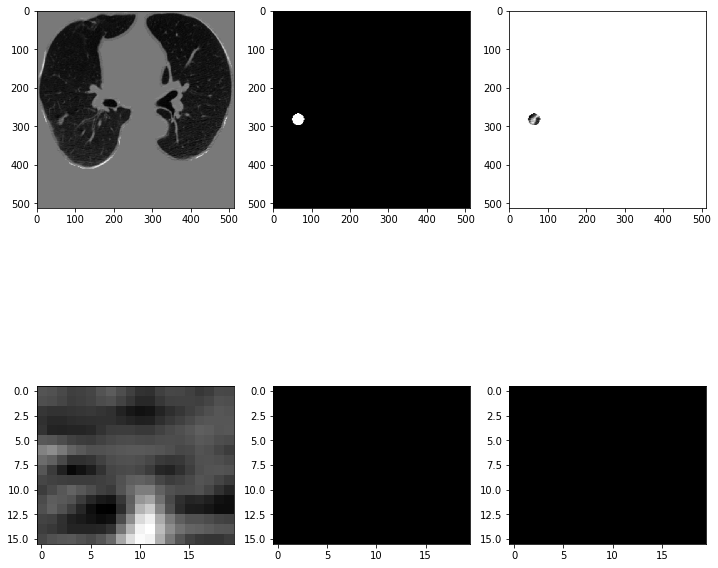

In [276]:
i = 6
yzoom, xzoom = slice(222, 238), slice(60, 80), 
print("image %d" % i)
fig,ax = plt.subplots(2,3,figsize=[12,12])
ax[0,0].imshow(np.squeeze(trainImages[i]),cmap='gray')
ax[0,1].imshow(np.squeeze(trainMasks[i]),cmap='gray')
ax[0,2].imshow((np.squeeze(trainImages[i])*np.squeeze(trainMasks[i])),cmap='gray')
ax[1,0].imshow(np.squeeze(trainImages[i])[yzoom, xzoom],cmap='gray')
ax[1,1].imshow(np.squeeze(trainMasks[i])[yzoom, xzoom],cmap='gray')
ax[1,2].imshow((np.squeeze(trainImages[i])*np.squeeze(trainMasks[i]))[yzoom, xzoom],cmap='gray')
plt.show()

In [264]:
np.squeeze(trainMasks[i])[222:238,60:80]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,